## Define constants

In [1]:
dataset_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
num_classes = 43
image_size = (32, 32)

## Preprocess function

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

def load_train_test_data(dataset_path, classes, image_size):

    data = []
    labels = []
    cur_path = os.getcwd()

    for i in range(classes):
        path = os.path.join(cur_path, dataset_path, str(i))
        images = os.listdir(path)

        for img in images:
            try:
                image = Image.open(path + "/" + img)
                image = image.resize(image_size)
                image = np.array(image)
                data.append(image)
                labels.append(i)
            except:
                print("Error loading image: " + path + "/" + img)

    data = np.array(data)
    labels = np.array(labels)

    X_train_valid, X_test, y_train_valid, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.25, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Splitting Training, Validation and Test data using preprocess function along with Data Augmentation

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train, X_valid, X_test, y_train, y_valid, y_test = load_train_test_data(dataset_path, num_classes, image_size)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

## VGG16

### Model

In [8]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

base_model = keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(32, 32, 3)
)

x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
output = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=output)

learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_valid, y_valid))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/25
736/736 [==============================] - 32s 34ms/step - loss: 2.7368 - accuracy: 0.1900 - val_loss: 2.0864 - val_accuracy: 0.2782
Epoch 2/25
736/736 [==============================] - 24s 33ms/step - loss: 1.7786 - accuracy: 0.3831 - val_loss: 3.6030 - val_accuracy: 0.4666
Epoch 3/25
736/736 [==============================] - 24s 33ms/step - loss: 1.1060 - accuracy: 0.5928 - val_loss: 0.6419 - val_accuracy: 0.7465
Epoch 4/25
736/736 [==============================] - 24s 33ms/step - loss: 0.7313 - accuracy: 0.7567 - val_loss: 0.3762 - val_accuracy: 0.8819
Epoch 5/25
736/736 [==============================] - 24s 33ms/step - loss: 0.3987 - accuracy: 0.8774 - val_loss: 0.4145 - val_accuracy: 0.8659
Epoch 6/25
736/736 [==============================] - 24s 33ms/step - loss: 0.2457 - accuracy: 0.9280 - val_loss: 0.1847 - val_accuracy: 0.9484
Epoch 7/25
736/736 [==============================] - 24s 33ms/step - l

### Accuracy vs Validation Accuracy

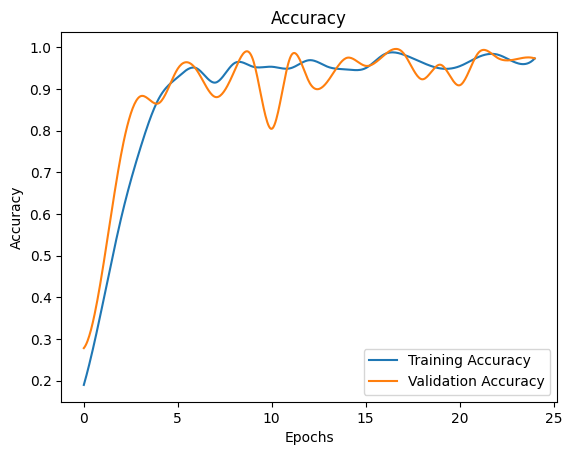

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

y_acc = np.array(history.history['accuracy'])
x_acc = np.array([i for i in range(len(y_acc))])
X_Y_Spline_acc = make_interp_spline(x_acc, y_acc)

X_acc = np.linspace(x_acc.min(), x_acc.max(), 500)
Y_acc = X_Y_Spline_acc(X_acc)

y_val = np.array(history.history['val_accuracy'])
x_val = np.array([i for i in range(len(y_val))])
X_Y_Spline_val = make_interp_spline(x_val, y_val)

X_val = np.linspace(x_val.min(), x_val.max(), 500)
Y_val = X_Y_Spline_val(X_val)

plt.plot(X_acc, Y_acc, label='Training Accuracy')
plt.plot(X_val, Y_val, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Loss vs Validation Loss

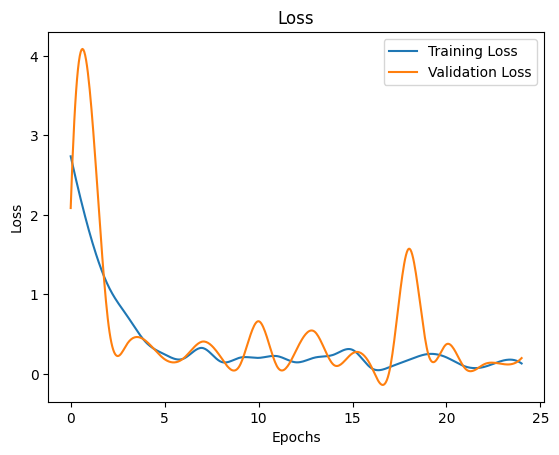

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

y_acc = np.array(history.history['loss'])
x_acc = np.array([i for i in range(len(y_acc))])
X_Y_Spline_acc = make_interp_spline(x_acc, y_acc)

X_acc = np.linspace(x_acc.min(), x_acc.max(), 500)
Y_acc = X_Y_Spline_acc(X_acc)

y_val = np.array(history.history['val_loss'])
x_val = np.array([i for i in range(len(y_val))])
X_Y_Spline_val = make_interp_spline(x_val, y_val)

X_val = np.linspace(x_val.min(), x_val.max(), 500)
Y_val = X_Y_Spline_val(X_val)

plt.plot(X_acc, Y_acc, label='Training Loss')
plt.plot(X_val, Y_val, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Confusion Matrix

246/246 [==============================] - 2s 8ms/step


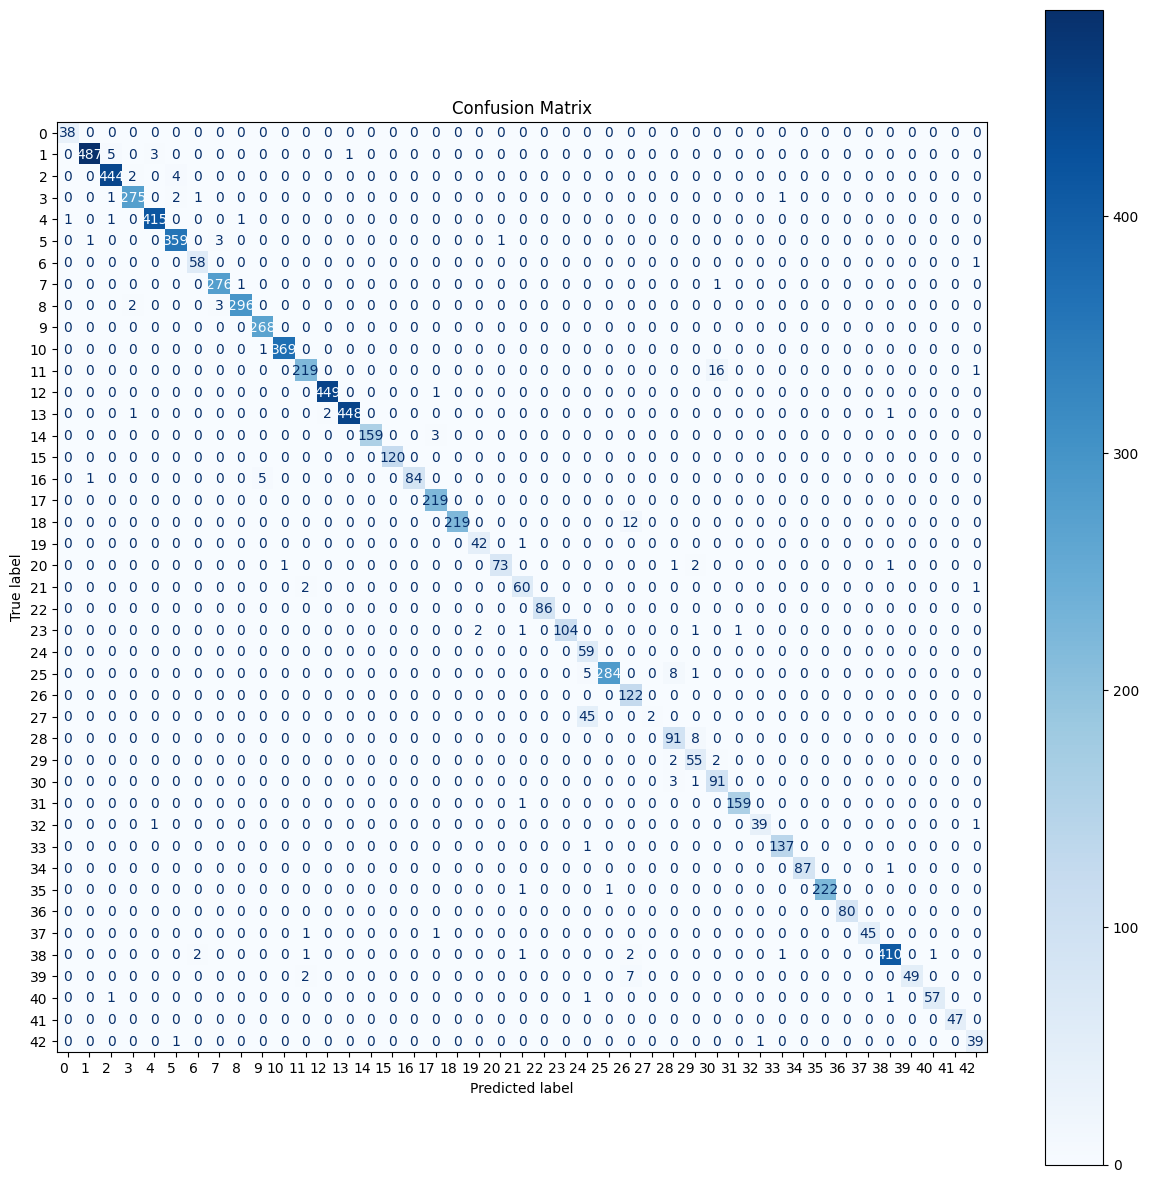

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

labels = [str(i) for i in range(num_classes)]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
